In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

In [4]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [5]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [6]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [7]:
ml_list={"LR":{"SYN":LogisticRegression(C=59.8441,penalty="l1",solver="liblinear" ),
               "HTTP":LogisticRegression(C=0.0463841 ,penalty="l2",solver="lbfgs" ),
               "ACK":LogisticRegression(C=0.204882 ,penalty="l2",solver="lbfgs" ),    
               "UDP":LogisticRegression(C=74.8807,penalty="none",solver="lbfgs" ),    
               "ARP":LogisticRegression(C=74.5065 ,penalty="l1",solver="liblinear" ),
               "SP":LogisticRegression(C=2.45721 ,penalty="none",solver="lbfgs" ),    
               "BF":LogisticRegression(C=27.4817 ,penalty="l1",solver="liblinear" ),    
               "OS":LogisticRegression(C= 29.4052,penalty="l1",solver="liblinear" ),
               "SCHD":LogisticRegression(C=0.820152,penalty="none",solver="lbfgs" ),    
               "MHDis":LogisticRegression(C=0.000453162,penalty="none",solver="lbfgs" )},   

"DT":{"SYN":DecisionTreeClassifier(criterion="gini",max_depth=6,max_features=10,min_samples_split=2 ),
"HTTP":DecisionTreeClassifier(criterion="gini",max_depth=6,max_features=10,min_samples_split=3 ),                      
"ACK":DecisionTreeClassifier(criterion="entropy",max_depth=3,max_features=4,min_samples_split=4),            
"UDP":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=20,min_samples_split=6 ),            
"ARP":DecisionTreeClassifier(criterion="gini",max_depth=17,max_features=51,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="entropy",max_depth=6,max_features=6,min_samples_split=2 ),            
"BF":DecisionTreeClassifier(criterion="entropy",max_depth=6,max_features=21,min_samples_split=3 ),              
"OS":DecisionTreeClassifier(criterion="entropy",max_depth=1,max_features=53,min_samples_split=4 ),            
"SCHD":DecisionTreeClassifier(criterion="entropy",max_depth=4,max_features=26,min_samples_split=9 ),             
"MHDis":DecisionTreeClassifier(criterion="gini",max_depth=7,max_features=12,min_samples_split=9 )},
         
               
    
"RF":{"SYN":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=7,max_features=8,min_samples_split=2,n_estimators=98),
"HTTP":RandomForestClassifier(bootstrap=True,criterion="gini",max_depth=7,max_features=9,min_samples_split=2,n_estimators=73),                      
"ACK":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=8,max_features=7,min_samples_split=8,n_estimators=55 ),            
"UDP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=14,max_features=3,min_samples_split=3,n_estimators=35 ),            
"ARP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=17,max_features=9,min_samples_split=2,n_estimators=140),            
"SP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=8,max_features=7,min_samples_split=2,n_estimators=1),            
"BF":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=5,max_features=9,min_samples_split=9,n_estimators=138 ),      
"OS":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=5,max_features=2,min_samples_split=6,n_estimators=3),            
"SCHD":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=13,max_features=9,min_samples_split=7,n_estimators=73),             
"MHDis":RandomForestClassifier(bootstrap=True,criterion="gini",max_depth=11,max_features=3,min_samples_split=5,n_estimators=75)},
         

    
"KNN":{"SYN":KNeighborsClassifier(algorithm="kd_tree",leaf_size=27,n_neighbors=11,weights="distance"),
"HTTP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=40,n_neighbors=2,weights="distance"),                     
"ACK":KNeighborsClassifier(algorithm="auto",leaf_size=13,n_neighbors=1,weights="distance"),        
"UDP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=45,n_neighbors=9,weights="uniform"),       
"ARP":KNeighborsClassifier(algorithm="kd_tree",leaf_size=10,n_neighbors=2,weights="distance"),         
"SP":KNeighborsClassifier(algorithm="auto",leaf_size=33,n_neighbors=1,weights="distance"),         
"BF":KNeighborsClassifier(algorithm="auto",leaf_size=10,n_neighbors=9,weights="distance"),    
"OS":KNeighborsClassifier(algorithm="brute",leaf_size=7,n_neighbors=10,weights="distance"),         
"SCHD":KNeighborsClassifier(algorithm="kd_tree",leaf_size=21,n_neighbors=1,weights="distance"),        
"MHDis":KNeighborsClassifier(algorithm="ball_tree",leaf_size=46,n_neighbors=1,weights="uniform")}
,


         
"SVM":{"SYN":SVC(gamma=1,C=10),
"HTTP":SVC(gamma=1,C=1),                  
"ACK":SVC(gamma=1,C=10),
"UDP":SVC(gamma=0.1,C=10),   
"ARP":SVC(gamma=0.01,C=1),       
"SP":SVC(gamma=1 ,C=1),      
"BF":SVC(gamma=0.01,C=10),  
"OS":SVC(gamma=0.01 ,C=10),
"SCHD":SVC(gamma=1,C=10),     
"MHDis":SVC(gamma=0.1,C=1)},
       

         
"MLP":{"SYN":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1184,433), alpha= 0.05, activation='relu'),
"HTTP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (439, ),  alpha= 0.0001, activation='relu'),             
"ACK":MLPClassifier(solver= 'lbfgs', learning_rate= 'adaptive', hidden_layer_sizes= (1193, 630),  alpha= 0.05, activation='tanh'),
"UDP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1391,1912),  alpha= 0.0001, activation='relu'),
"ARP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1015, ),  alpha= 0.1, activation='relu'),    
"SP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes=  (851,318),  alpha= 0.0001, activation='relu'), 
"BF":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1129,732), alpha= 0.001, activation='relu'),
"OS":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (851,318), alpha= 0.01, activation='tanh'),
"SCHD":MLPClassifier(solver= 'lbfgs', learning_rate= 'adaptive', hidden_layer_sizes= (310,1163), alpha= 0.1, activation='tanh'),
"MHDis":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1568,1928), alpha= 0.01, activation='tanh')},
                
         
"NB":{"SYN":GaussianNB(var_smoothing=1.23285e-09),
"HTTP":GaussianNB(var_smoothing=1e-09 ),                  
"ACK":GaussianNB(var_smoothing= 2.84804e-07),
"UDP":GaussianNB(var_smoothing=1.23285e-09),  
"ARP":GaussianNB(var_smoothing=1.23285e-08),    
"SP":GaussianNB(var_smoothing=1e-09 ),      
"BF":GaussianNB(var_smoothing= 0.053367),  
"OS":GaussianNB(var_smoothing=1e-09 ),
"SCHD":GaussianNB(var_smoothing=0.00432876 ),  
"MHDis":GaussianNB(var_smoothing=1e-09)},
         
         
        "XGB":{"SYN":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=4,max_depth=2,learning_rate=0.2),
               "HTTP":xgboost.XGBClassifier(n_estimators=900,min_child_weight=3,max_depth=2,learning_rate=0.15),
               "ACK":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=1,max_depth=2,learning_rate=0.15),    
               "UDP":xgboost.XGBClassifier(n_estimators=900,min_child_weight=2,max_depth=2,learning_rate=0.15),
               "ARP":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=3,max_depth=2,learning_rate=0.2),
               "SP":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=1,max_depth=3,learning_rate=0.2),    
               "BF":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=4,max_depth=2,learning_rate=0.05),   
               "OS":xgboost.XGBClassifier(n_estimators=100,min_child_weight=3,max_depth=2,learning_rate=0.15),
               "SCHD":xgboost.XGBClassifier(n_estimators=100,min_child_weight=2,max_depth=2,learning_rate=0.1),  
               "MHDis":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=2,max_depth=2,learning_rate=0.15),
              }}


In [8]:
ml_list={                  
"MLP":{"SYN":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1184,433), alpha= 0.05, activation='relu'),
"HTTP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (439, ),  alpha= 0.0001, activation='relu'),             
"ACK":MLPClassifier(solver= 'lbfgs', learning_rate= 'adaptive', hidden_layer_sizes= (1193, 630),  alpha= 0.05, activation='tanh'),
"UDP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1391,1912),  alpha= 0.0001, activation='relu'),
"ARP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1015, ),  alpha= 0.1, activation='relu'),    
"SP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes=  (851,318),  alpha= 0.0001, activation='relu'), 
"BF":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1129,732), alpha= 0.001, activation='relu'),
"OS":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (851,318), alpha= 0.01, activation='tanh'),
"SCHD":MLPClassifier(solver= 'lbfgs', learning_rate= 'adaptive', hidden_layer_sizes= (310,1163), alpha= 0.1, activation='tanh'),
"MHDis":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1568,1928), alpha= 0.01, activation='tanh')},
        
"SVM":{"SYN":SVC(gamma=1,C=10),
"HTTP":SVC(gamma=1,C=1),                  
"ACK":SVC(gamma=1,C=10),
"UDP":SVC(gamma=0.1,C=10),   
"ARP":SVC(gamma=0.01,C=1),       
"SP":SVC(gamma=1 ,C=1),      
"BF":SVC(gamma=0.01,C=10),  
"OS":SVC(gamma=0.01 ,C=10),
"SCHD":SVC(gamma=1,C=10),     
"MHDis":SVC(gamma=0.1,C=1)}}

In [9]:
import time

# sleep for 3 seconds
print('Sleep time: ', str(3600), 'seconds')
#time.sleep(7200)
print('Woke up after: ', str(3), 'seconds')


Sleep time:  3600 seconds
Woke up after:  3 seconds


In [10]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [11]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")


## Calculation of evaluations

In [12]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [13]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  



                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))

        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


In [14]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  




            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


# GA output

In [15]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [24]:
file_list={'./INPUT/SM/DoS-SYN-1.csv':"SYN",
'./INPUT/SM/MB-HTTP-4.csv':"HTTP",
'./INPUT/SM/MB-ACK-4.csv':"ACK",
'./INPUT/SM/MB-UDP-4.csv':"UDP",
'./INPUT/SM/MitM-ARP-6.csv':"ARP",
'./INPUT/SM/Scan-Port-3.csv':"SP",
'./INPUT/SM/MB-BF-5.csv':"BF",
'./INPUT/SM/Scan-OS-3.csv':"OS",  
'./INPUT/SM/Scan-HDis-3.csv':"SCHD",
'./INPUT/SM/MB-HDis-3.csv':"MHDis"}

./INPUT/SM/DoS-SYN-1.csv
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  MLP   0.999    0.999   0.999  0.999  0.999  0.998  0.999   59.911     0.054
 1  SYN           0    2     0  MLP   0.999    0.999   0.999  0.999  0.999  0.998  0.999  311.075     0.322
 2  SYN           0    3     0  MLP   0.999    0.999   0.999  0.999  0.999  0.998  0.999   50.956   

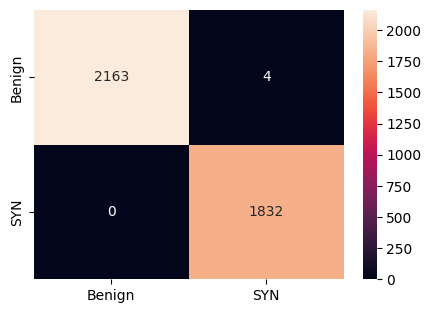





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  SVM   0.944    0.938   0.955  0.938  0.943  0.886  0.938   26.966     2.152
 1  SYN           0    2     0  SVM   0.945    0.94    0.954  0.94   0.944  0.888  0.94    28.193     2.162
 2  SYN           0    3     0  SVM   0.948    0.944   0.955  0.944  0.947  0.894  0.944   27.097     2.174
 3  SYN           0    4     0  SVM   0.944    0.939   0.953  0.939  0.943  0.887  0.939   27.704     2.175
 4  SYN           0    5     0  SVM   0.947    0.943   0.955  0.943  0.946  0.893  0.943   28.083     2.173
 5  SYN           0    1     1  SVM   0.946    0.941   0.954  0.941  0.945  0.89   0.941   26.967     2.172
 6  SYN           0    2     1  SVM   0.937    0.933   0.947  0.933  0.936  0.873  0.933   27.166     2.385
 7  SYN           0    3

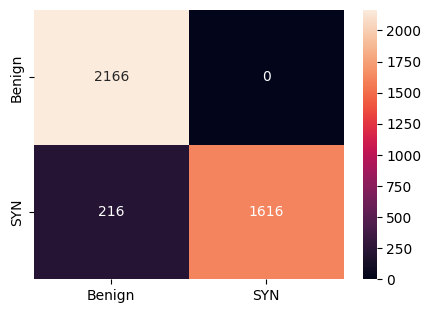





./INPUT/SM/MB-HTTP-4.csv
['ts', 'TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_PSH_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  MLP   0.999    0.988   0.999  0.988  0.994  0.987  0.988    2.411     0.006
 1  HTTP          0    2     0  MLP   0.999    0.993   0.993  0.993  0.993  0.987  0.993    2.839     0.006
 2  HTTP          0    3     0  MLP   0.996    0.989   0.963  0.989  0.976  0.952  0.989    3.453     0.006
 3  HTTP          0    4     0  MLP   1        0.997   1      0.997  0.998  0.997  0.997    4.343     0.006
 4  HTTP          0    5     0  MLP   0.998    0.

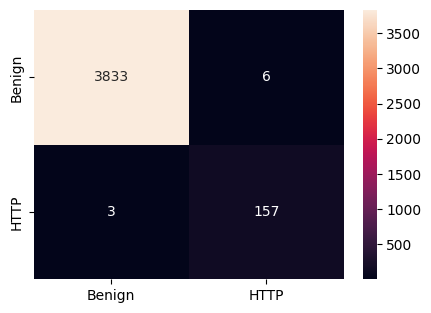





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  SVM   0.963      0.5   0.482    0.5  0.491      0    0.5   34.265     2.875
 1  HTTP          0    2     0  SVM   0.959      0.5   0.48     0.5  0.49       0    0.5   39.016     2.87
 2  HTTP          0    3     0  SVM   0.959      0.5   0.48     0.5  0.49       0    0.5   38.286     2.853
 3  HTTP          0    4     0  SVM   0.958      0.5   0.479    0.5  0.489      0    0.5   37.005     2.875
 4  HTTP          0    5     0  SVM   0.96       0.5   0.48     0.5  0.49       0    0.5   40.558     2.914
 5  HTTP          0    1     1  SVM   0.959      0.5   0.479    0.5  0.489      0    0.5   38.118     2.876
 6  HTTP          0    2     1  SVM   0.96       0.5   0.48     0.5  0.49       0    0.5   40.141     2.867
 7  HTTP          0    3 

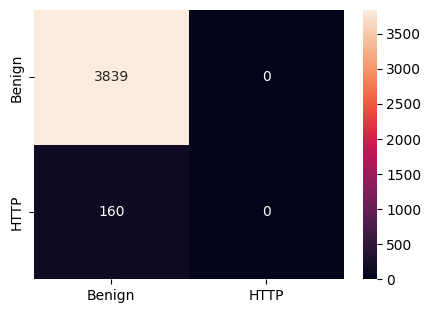





./INPUT/SM/MB-ACK-4.csv
['payload_bytes_mean_WE', 'sport_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  MLP       1    1           1  1      1      1      1       13.4       0.135
 1  ACK           0    2     0  MLP       1    0.996       1  0.996  0.998  0.996  0.996   16.843     0.128
 2  ACK           0    3     0  MLP       1    1           1  1      1      1      1       19.52      0.132
 3  ACK           0    4     0  MLP       1    1           1  1      1      1      1       17.671     0.132
 4  ACK           0    5     0  MLP       1    1           1  1      1      1      1       17.693     0.126
 5  ACK           0    1     1  MLP       1    1           1  1      1      1      1       17.688     0.134
 6  ACK         

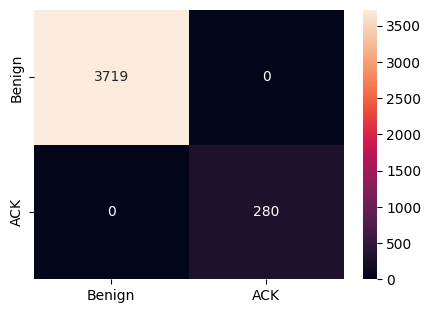





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  SVM   0.952    0.639   0.976  0.639  0.705  0.418  0.639   16.458     1.063
 1  ACK           0    2     0  SVM   0.948    0.624   0.973  0.624  0.685  0.381  0.624   16.407     1.058
 2  ACK           0    3     0  SVM   0.948    0.634   0.974  0.634  0.698  0.406  0.634   16.396     1.046
 3  ACK           0    4     0  SVM   0.948    0.638   0.973  0.638  0.702  0.414  0.638   16.217     1.045
 4  ACK           0    5     0  SVM   0.946    0.627   0.973  0.627  0.689  0.388  0.627   16.574     1.197
 5  ACK           0    1     1  SVM   0.945    0.628   0.972  0.628  0.69   0.39   0.628   16.686     1.065
 6  ACK           0    2     1  SVM   0.954    0.655   0.976  0.655  0.724  0.456  0.655   16.268     1.046
 7  ACK           0    3

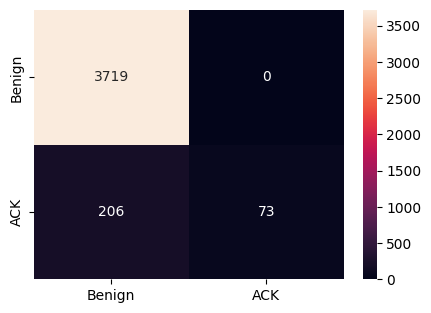





./INPUT/SM/MB-UDP-4.csv
['IP_tos', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'TCP_window_sum_of_EW', 'entropy_diff', 'ts_std_2', 'TCP_window_mean_2', 'entropy_std_2', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_mean_9', 'entropy_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  MLP   0.999    0.999   0.999  0.999  0.999  0.998  0.999  201.313     0.179
 1  UDP           0    2     0  MLP   1        1       1      1      1      1      1      317.016     0.184
 2  UDP           0    3     0  MLP   1        1       1      1      1      1      1      258.179     0.174
 3  UDP           0    4     0  MLP   0.999    0.999   0.999  0.9

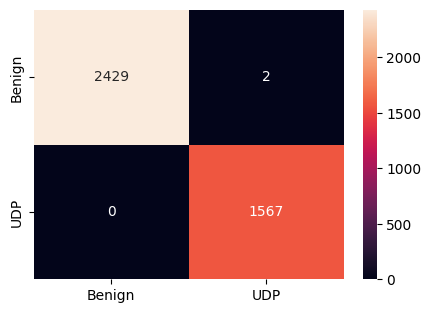





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  SVM       1        1       1      1     1      1      1    0.074     0.004
 1  UDP           0    2     0  SVM       1        1       1      1     1      1      1    0.086     0.004
 2  UDP           0    3     0  SVM       1        1       1      1     1      1      1    0.07      0.003
 3  UDP           0    4     0  SVM       1        1       1      1     1      1      1    0.056     0.004
 4  UDP           0    5     0  SVM       1        1       1      1     1      1      1    0.087     0.003
 5  UDP           0    1     1  SVM       1        1       1      1     1      1      1    0.083     0.003
 6  UDP           0    2     1  SVM       1        1       1      1     1      1      1    0.085     0.003
 7  UDP           0    3     1  S

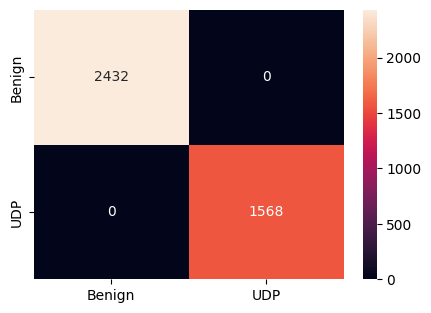





./INPUT/SM/MitM-ARP-6.csv
['Ether_type', 'IP_tos', 'IP_flags', 'IP_MF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_reserved', 'TCP_ACK', 'TCP_ECE', 'TCP_CWR', 'UDP_len', 'DNS_qr', 'DNS_ra', 'DNS_qdcount', 'DNS_nscount', 'DNS_arcount', 'payload_bytes', 'entropy', 'Protocol', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_mean_WE', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'entropy_mean_2', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_CWR_ratio', 'TCP_RST_SR', 'TCP_PSH_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'entropy_mean_6', 'entropy_std_6', 'pck_size_mean_9', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_std_9', 'T

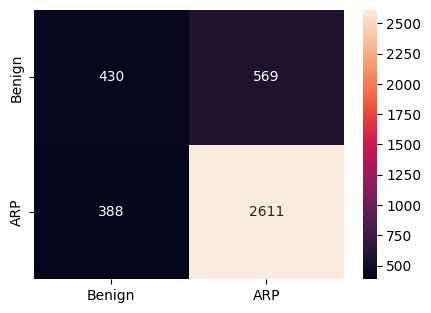





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  SVM   0.76     0.509   0.879  0.509  0.45   0.028  0.509   66.584     4.738
 1  ARP           0    2     0  SVM   0.743    0.51    0.871  0.51   0.445  0.028  0.51    58.643     4.702
 2  ARP           0    3     0  SVM   0.764    0.509   0.881  0.509  0.45   0.027  0.509   75.648     4.704
 3  ARP           0    4     0  SVM   0.761    0.51    0.88   0.51   0.451  0.029  0.51    63.56      4.702
 4  ARP           0    5     0  SVM   0.744    0.507   0.872  0.507  0.44   0.02   0.507   71.617     4.705
 5  ARP           0    1     1  SVM   0.762    0.512   0.88   0.512  0.455  0.035  0.512   64.41      4.715
 6  ARP           0    2     1  SVM   0.758    0.51    0.879  0.51   0.45   0.029  0.51    75.804     4.708
 7  ARP           0    3

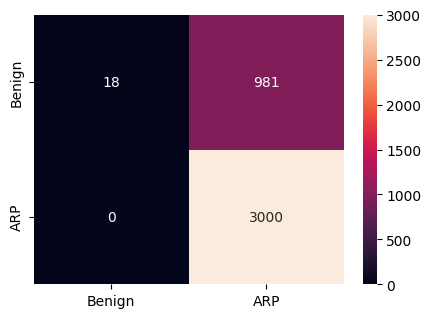





./INPUT/SM/Scan-Port-3.csv
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'entropy_sum_of_EW', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  MLP       1    1           1  1      1      1      1        6.404     0.016
 1  SP            0    2     0  MLP       1    1           1  1      1      1      1        8.183     0.016
 2  SP            0    3     0  MLP       1    0.998       1  0.998  0.999  0.998  0.998    6.845     0.017
 3  SP            0    4     0  MLP       1    1           1  1      1      1      1        7.718     0.016
 4  SP            0    5     0  MLP       1    1           1  1      1      1      1        7.706     0.016
 5  SP            0    1     1  MLP       1    1           1  1      1      

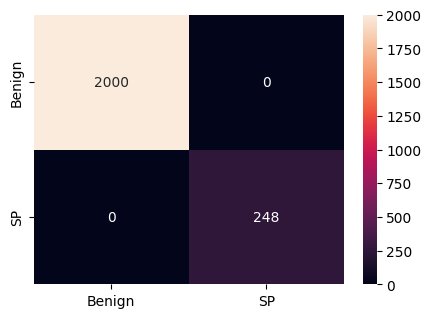





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  SVM   0.894    0.5     0.447  0.5    0.472  0      0.5      6.335     0.895
 1  SP            0    2     0  SVM   0.88     0.5     0.44   0.5    0.468  0      0.5      6.267     0.899
 2  SP            0    3     0  SVM   0.887    0.5     0.444  0.5    0.47   0      0.5      5.986     0.896
 3  SP            0    4     0  SVM   0.892    0.5     0.446  0.5    0.471  0      0.5      6.114     0.91
 4  SP            0    5     0  SVM   0.895    0.5     0.448  0.5    0.472  0      0.5      6.002     0.896
 5  SP            0    1     1  SVM   0.898    0.502   0.949  0.502  0.477  0.008  0.502    6.248     0.906
 6  SP            0    2     1  SVM   0.881    0.5     0.44   0.5    0.468  0      0.5      5.756     0.898
 7  SP            0    3 

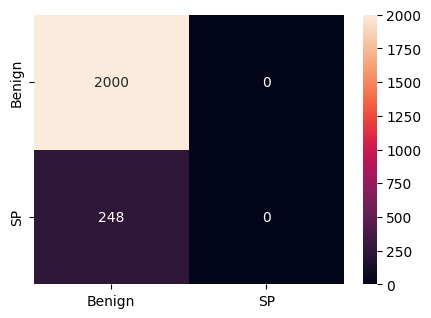





./INPUT/SM/MB-BF-5.csv
['payload_bytes', 'pck_size_diff', 'TCP_window_diff', 'entropy_mean_WE', 'pck_size_mean_2', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_ratio', 'TCP_FIN_SR', 'pck_size_mean_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  MLP   0.993    0.969   0.957  0.969  0.963  0.926  0.969   38.047     0.033
 1  BF            0    2     0  MLP   0.987    0.909   0.94   0.909  0.924  0.847  0.909   47.326     0.033
 2  BF            0    3     0  MLP   0.9

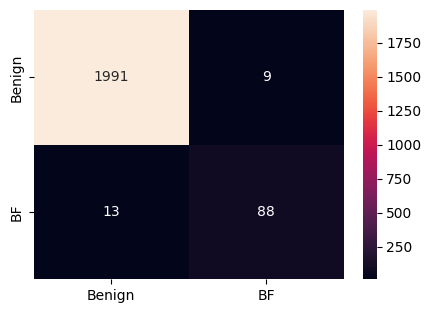





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  SVM   0.996    0.958   0.998  0.958  0.977  0.954  0.958    2.69      0.519
 1  BF            0    2     0  SVM   0.995    0.944   0.997  0.944  0.969  0.938  0.944    2.618     0.528
 2  BF            0    3     0  SVM   0.994    0.941   0.997  0.941  0.967  0.935  0.941    2.641     0.521
 3  BF            0    4     0  SVM   0.996    0.953   0.998  0.953  0.974  0.949  0.953    2.687     0.515
 4  BF            0    5     0  SVM   0.995    0.954   0.998  0.954  0.974  0.949  0.954    2.661     0.516
 5  BF            0    1     1  SVM   0.997    0.971   0.999  0.971  0.985  0.969  0.971    3.419     0.519
 6  BF            0    2     1  SVM   0.992    0.922   0.996  0.922  0.955  0.911  0.922    2.823     0.515
 7  BF            0    3

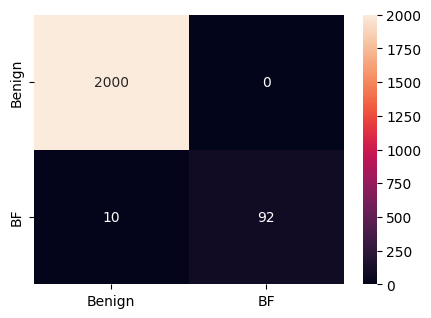





./INPUT/SM/Scan-OS-3.csv
['IP_ttl', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_ECE', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'dport_class', 'Protocol', 'dst_IP_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'payload_bytes_std_2', 'entropy_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_URG_ratio', 'TCP_ECE_ratio', 'TCP_CWR_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_ECE_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec  

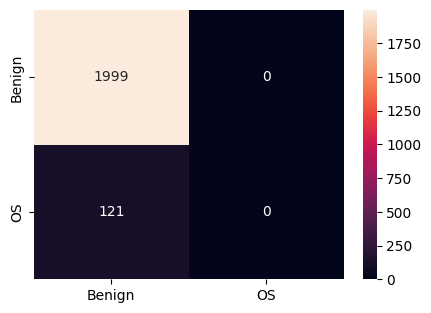





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  SVM   0.951      0.5   0.476    0.5  0.488      0    0.5   10.39      1.123
 1  OS            0    2     0  SVM   0.934      0.5   0.467    0.5  0.483      0    0.5    9.041     1.122
 2  OS            0    3     0  SVM   0.941      0.5   0.471    0.5  0.485      0    0.5   10.24      1.142
 3  OS            0    4     0  SVM   0.944      0.5   0.472    0.5  0.486      0    0.5   10.57      1.133
 4  OS            0    5     0  SVM   0.944      0.5   0.472    0.5  0.486      0    0.5   11.825     1.122
 5  OS            0    1     1  SVM   0.941      0.5   0.471    0.5  0.485      0    0.5   10.133     1.153
 6  OS            0    2     1  SVM   0.947      0.5   0.474    0.5  0.486      0    0.5   10.486     1.134
 7  OS            0    3

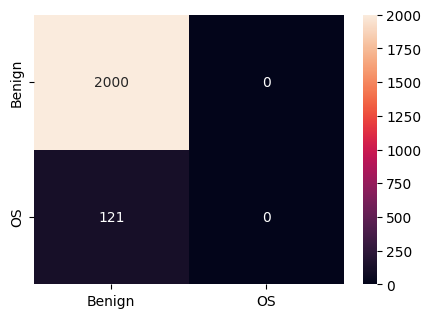





./INPUT/SM/Scan-HDis-3.csv
['Ether_type', 'IP_version', 'IP_DF', 'IP_ttl', 'TCP_flags', 'TCP_options', 'dport_class', 'Protocol', 'IP_add_count', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'TCP_window_mean_WE', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'entropy_std_WE', 'pck_size_mean_2', 'ts_std_2', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  MLP       1        1   0.995      1  0.998  0.995      1  128.052     0.051
 1  SCHD          0    2     0  MLP       1        1   1          1  1      1          1  125.28      0.051
 2  SCHD          0    3 

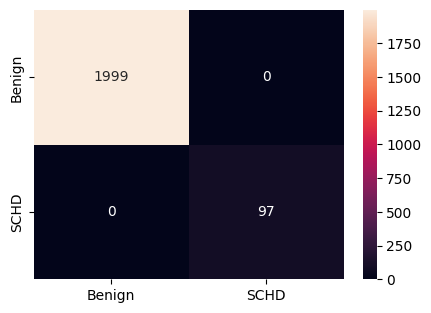





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SCHD          0    1     0  SVM       1        1       1      1     1      1      1    3.345     0.81
 1  SCHD          0    2     0  SVM       1        1       1      1     1      1      1    3.235     0.814
 2  SCHD          0    3     0  SVM       1        1       1      1     1      1      1    3.527     0.809
 3  SCHD          0    4     0  SVM       1        1       1      1     1      1      1    3.561     0.817
 4  SCHD          0    5     0  SVM       1        1       1      1     1      1      1    3.158     0.817
 5  SCHD          0    1     1  SVM       1        1       1      1     1      1      1    3.435     0.82
 6  SCHD          0    2     1  SVM       1        1       1      1     1      1      1    3.321     0.814
 7  SCHD          0    3     1  SVM

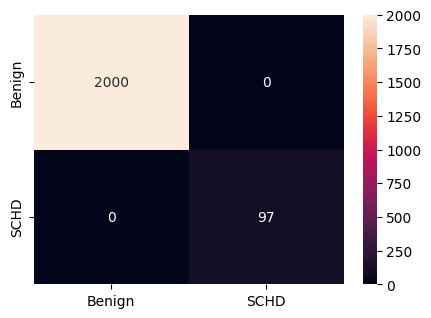





./INPUT/SM/MB-HDis-3.csv
['IP_ihl', 'IP_ttl', 'TCP_options', 'sport_class', 'Protocol', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'TCP_ACK_sum', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  MLP   1        1       0.987  1      0.993  0.987  1      380.638     0.156
 1  MHDis         0    2     0  MLP   1        1       0.988  1      0.994  0.987  1      299.455     0.16
 2  MHDis         0    3     0  MLP   1        1       1      1      1      1      1      358.24      0.157
 3  MHDis         0    4     0  MLP   0.998    0.957   0.999  0.957  0.977  0.955  0.957  275.723     0.156
 4  MHDis         0    5     0  

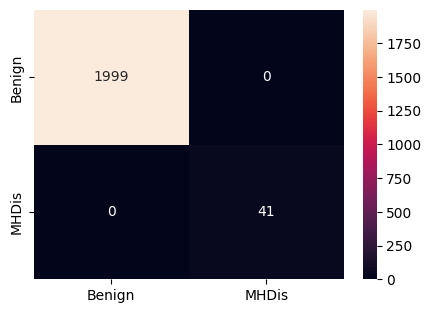





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  SVM   0.982    0.526   0.991  0.526  0.546  0.098  0.526    5.963     0.782
 1  MHDis         0    2     0  SVM   0.982    0.538   0.991  0.538  0.565  0.137  0.538    5.791     0.788
 2  MHDis         0    3     0  SVM   0.981    0.568   0.991  0.568  0.615  0.236  0.568    6.269     0.813
 3  MHDis         0    4     0  SVM   0.979    0.522   0.989  0.522  0.537  0.083  0.522    4.469     0.79
 4  MHDis         0    5     0  SVM   0.979    0.512   0.99   0.512  0.518  0.045  0.512    4.933     0.786
 5  MHDis         0    1     1  SVM   0.983    0.551   0.991  0.551  0.589  0.183  0.551    6.111     0.784
 6  MHDis         0    2     1  SVM   0.98     0.512   0.99   0.512  0.519  0.047  0.512    5.226     0.787
 7  MHDis         0    3 

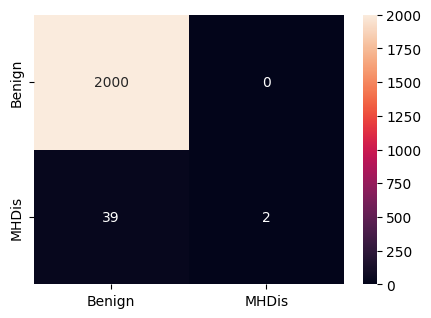

In [25]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


# SS

In [16]:
file_list={"SYN":['./INPUT/SM/DoS-SYN-1.csv','./INPUT/SM/DoS-SYN-2.csv'],
"HTTP":['./INPUT/SM/MB-HTTP-4.csv','./INPUT/SM/MB-HTTP-1.csv'],
"ACK":['./INPUT/SM/MB-ACK-4.csv','./INPUT/SM/MB-ACK-1.csv'],
"UDP":['./INPUT/SM/MB-UDP-4.csv','./INPUT/SM/MB-UDP-1.csv'],
"ARP":['./INPUT/SM/MitM-ARP-6.csv','./INPUT/SM/MitM-ARP-4.csv'],  
"SP":['./INPUT/SM/Scan-Port-3.csv','./INPUT/SM/Scan-Port-4.csv'],
"BF":['./INPUT/SM/MB-BF-5.csv','./INPUT/SM/MB-BF-3.csv'],
"OS":['./INPUT/SM/Scan-OS-3.csv','./INPUT/SM/Scan-OS-6.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SM/MB-HDis-2.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SM/Scan-HDis-4.csv' ]}
 

In [17]:
ml_list={ 
"SVM":{"SYN":SVC(gamma=1,C=10),
"HTTP":SVC(gamma=1,C=1),                  
"ACK":SVC(gamma=1,C=10),
"UDP":SVC(gamma=0.1,C=10),   
"ARP":SVC(gamma=0.01,C=1),       
"SP":SVC(gamma=1 ,C=1),      
"BF":SVC(gamma=0.01,C=10),  
"OS":SVC(gamma=0.01 ,C=10),
"SCHD":SVC(gamma=1,C=10),     
"MHDis":SVC(gamma=0.1,C=1)}}

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  SVM   0.953    0.945   0.962  0.945  0.951  0.902  0.945   75.014    16.358
 1  SYN           0    1     1  SVM   0.953    0.945   0.962  0.945  0.951  0.902  0.945   73.217    16.454
 2  SYN           0    1     2  SVM   0.953    0.945   0.962  0.945  0.951  0.902  0.945   72.951    16.274
 3  SYN      

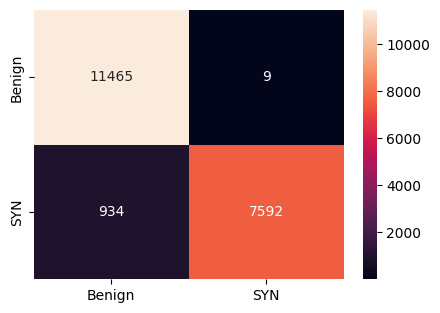





HTTP
['ts', 'TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_PSH_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  SVM   0.944      0.5   0.472    0.5  0.486      0    0.5   79.874    14.803
 1  HTTP          0    1     1  SVM   0.944      0.5   0.472    0.5  0.486      0    0.5   79.9      14.774
 2  HTTP          0    1     2  SVM   0.944      0.5   0.472    0.5  0.486      0    0.5   79.537    14.722
 3  HTTP          0    1     3  SVM   0.944      0.5   0.472    0.5  0.486      0    0.5   79.871    14.731
 4  HTTP          0    1     4  SVM   0.944      0.5   0.472    0.5  

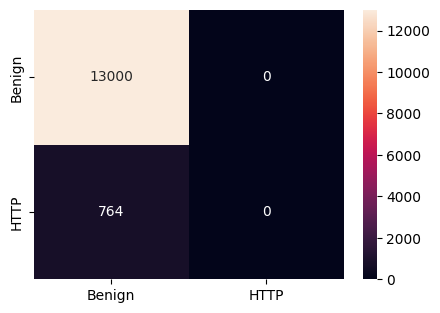





ACK
['payload_bytes_mean_WE', 'sport_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  SVM   0.306    0.501   0.653  0.501  0.235  0.001  0.501   29.228     6.701
 1  ACK           0    1     1  SVM   0.306    0.501   0.653  0.501  0.235  0.001  0.501   29.183     6.698
 2  ACK           0    1     2  SVM   0.306    0.501   0.653  0.501  0.235  0.001  0.501   29.259     6.708
 3  ACK           0    1     3  SVM   0.306    0.501   0.653  0.501  0.235  0.001  0.501   29.26      6.7
 4  ACK           0    1     4  SVM   0.306    0.501   0.653  0.501  0.235  0.001  0.501   29.91      6.771
 5  ACK           0    1     5  SVM   0.306    0.501   0.653  0.501  0.235  0.001  0.501   30.452     6.782
 6  ACK           0    1     6  SVM   

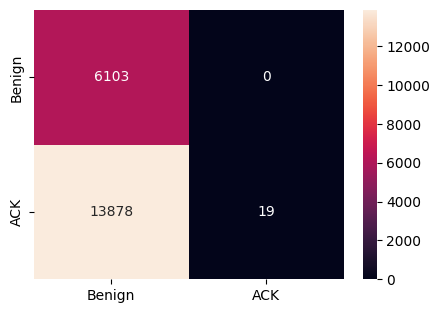





UDP
['IP_tos', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'TCP_window_sum_of_EW', 'entropy_diff', 'ts_std_2', 'TCP_window_mean_2', 'entropy_std_2', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_mean_9', 'entropy_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  SVM       1        1       1      1     1      1      1    0.133     0.029
 1  UDP           0    1     1  SVM       1        1       1      1     1      1      1    0.155     0.029
 2  UDP           0    1     2  SVM       1        1       1      1     1      1      1    0.151     0.029
 3  UDP           0    1     3  SVM       1        1       1      1     1      1      1   

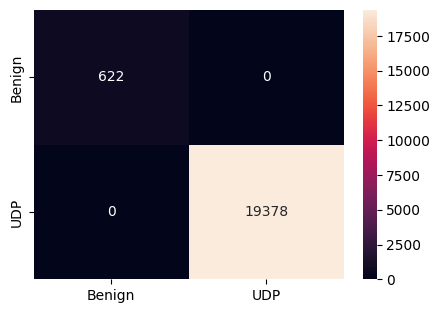





ARP
['Ether_type', 'IP_tos', 'IP_flags', 'IP_MF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_reserved', 'TCP_ACK', 'TCP_ECE', 'TCP_CWR', 'UDP_len', 'DNS_qr', 'DNS_ra', 'DNS_qdcount', 'DNS_nscount', 'DNS_arcount', 'payload_bytes', 'entropy', 'Protocol', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_mean_WE', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'entropy_mean_2', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_CWR_ratio', 'TCP_RST_SR', 'TCP_PSH_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'entropy_mean_6', 'entropy_std_6', 'pck_size_mean_9', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_std_9', 'TCP_SYN_R', 'Label']
  

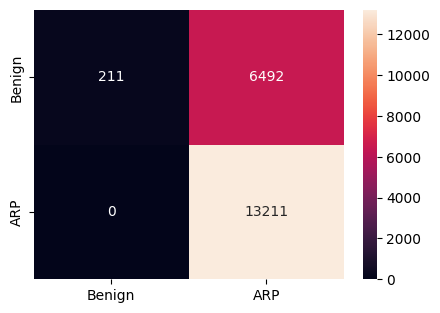





SP
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'entropy_sum_of_EW', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  SVM   0.861    0.586   0.928  0.586  0.608  0.256  0.586   13.952     4.082
 1  SP            0    1     1  SVM   0.861    0.586   0.928  0.586  0.608  0.256  0.586   13.948     4.088
 2  SP            0    1     2  SVM   0.861    0.586   0.928  0.586  0.608  0.256  0.586   13.956     4.102
 3  SP            0    1     3  SVM   0.861    0.586   0.928  0.586  0.608  0.256  0.586   13.916     4.096
 4  SP            0    1     4  SVM   0.861    0.586   0.928  0.586  0.608  0.256  0.586   13.91      4.091
 5  SP            0    1     5  SVM   0.861    0.586   0.928  0.586  0.608  0.256  0.586   13.974   

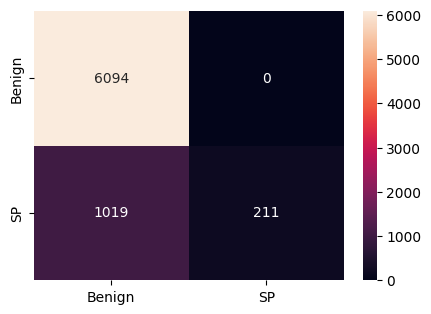





BF
['payload_bytes', 'pck_size_diff', 'TCP_window_diff', 'entropy_mean_WE', 'pck_size_mean_2', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_ratio', 'TCP_FIN_SR', 'pck_size_mean_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  SVM   0.995    0.948   0.997  0.948  0.971  0.943  0.948    7.076     3.606
 1  BF            0    1     1  SVM   0.995    0.948   0.997  0.948  0.971  0.943  0.948    7.055     3.606
 2  BF            0    1     2  SVM   0.995    0.948   0.997 

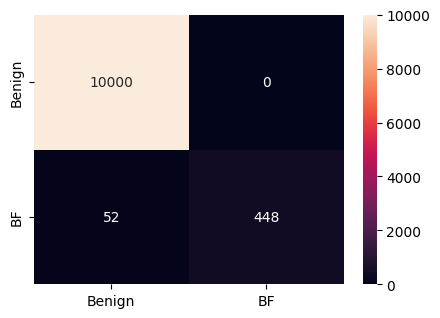





OS
['IP_ttl', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_ECE', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'dport_class', 'Protocol', 'dst_IP_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'payload_bytes_std_2', 'entropy_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_URG_ratio', 'TCP_ECE_ratio', 'TCP_CWR_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_ECE_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap   

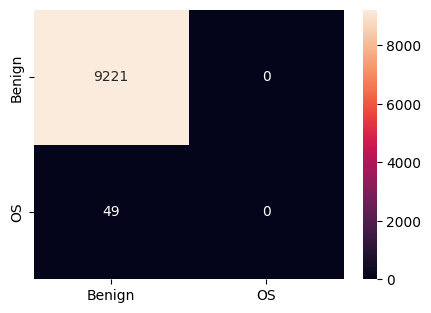





SCHD
['Ether_type', 'IP_version', 'IP_DF', 'IP_ttl', 'TCP_flags', 'TCP_options', 'dport_class', 'Protocol', 'IP_add_count', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'TCP_window_mean_WE', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'entropy_std_WE', 'pck_size_mean_2', 'ts_std_2', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  SVM    0.99      0.5   0.495    0.5  0.497      0    0.5    9.793     6.049
 1  SCHD          0    1     1  SVM    0.99      0.5   0.495    0.5  0.497      0    0.5    9.719     5.938
 2  SCHD          0    1     2  SVM    0.99    

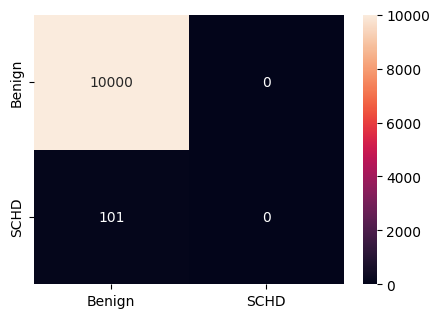





MHDis
['IP_ihl', 'IP_ttl', 'TCP_options', 'sport_class', 'Protocol', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'TCP_ACK_sum', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  SVM   0.934    0.555   0.888  0.555  0.581  0.182  0.555   14.917     3.674
 1  MHDis         0    1     1  SVM   0.934    0.555   0.888  0.555  0.581  0.182  0.555   14.341     3.676
 2  MHDis         0    1     2  SVM   0.934    0.555   0.888  0.555  0.581  0.182  0.555   14.911     3.69
 3  MHDis         0    1     3  SVM   0.934    0.555   0.888  0.555  0.581  0.182  0.555   15         3.679
 4  MHDis         0    1     4  SVM   0.934    0.55

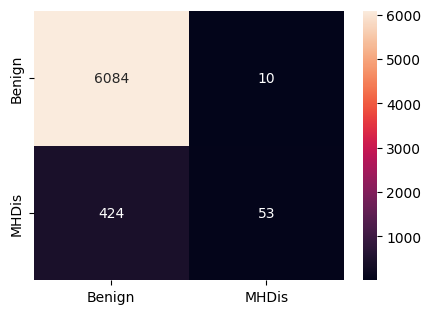

In [18]:
folder("results/val/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   


# TEST

In [19]:
file_list={'SYN': ['./INPUT/SM/DoS-SYN-1.csv',  './INPUT/TEST/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237._SW.csv'],
 'HTTP': ['./INPUT/SM/MB-HTTP-4.csv',  './INPUT/TEST/NetatmoCamHTTPFlood_1_SW.csv'],
'ACK': ['./INPUT/SM/MB-ACK-4.csv',  './INPUT/TEST/NetatmoCamTCPFlood_3_SW.csv'],
 'UDP': ['./INPUT/SM/MB-UDP-4.csv',  './INPUT/TEST/Bot_IoT_UDP_DDoS_00001._SW.csv'],
 'ARP': ['./INPUT/SM/MitM-ARP-6.csv',   './INPUT/TEST/Kitsune_ARP_MitM._SW.csv'],
 'SP': ['./INPUT/SM/Scan-Port-3.csv', './INPUT/TEST/IoT_ENV_[Port_scan]Google_Home_Mini_SW.csv'],
 'BF': ['./INPUT/SM/MB-BF-5.csv',  './INPUT/TEST/AmcrestCamBruteForce_1_SW.csv'],
 'OS': ['./INPUT/SM/Scan-OS-3.csv',  './INPUT/TEST/IoT_ENV_[OS_Service_Detection]Google_Home_Mini_SW.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SM/MB-HDis-3.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SM/Scan-HDis-3.csv' ]}

In [20]:
file_list={'SYN': ['./INPUT/SM/DoS-SYN-1.csv',  './INPUT/TEST/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237._SW.csv'],
 'HTTP': ['./INPUT/SM/MB-HTTP-4.csv',  './INPUT/TEST/NetatmoCamHTTPFlood_1_SW.csv'],
'ACK': ['./INPUT/SM/MB-ACK-4.csv',  './INPUT/TEST/NetatmoCamTCPFlood_3_SW.csv'],
 'UDP': ['./INPUT/SM/MB-UDP-4.csv',  './INPUT/TEST/Bot_IoT_UDP_DDoS_00001._SW.csv'],
 'ARP': ['./INPUT/SM/MitM-ARP-6.csv',   './INPUT/TEST/Kitsune_ARP_MitM._SW.csv'],
 'SP': ['./INPUT/SM/Scan-Port-3.csv', './INPUT/TEST/IoT_ENV_[Port_scan]Google_Home_Mini_SW.csv'],
 'BF': ['./INPUT/SM/MB-BF-5.csv',  './INPUT/TEST/AmcrestCamBruteForce_1_SW.csv'],
 'OS': ['./INPUT/SM/Scan-OS-3.csv',  './INPUT/TEST/IoT_ENV_[OS_Service_Detection]Google_Home_Mini_SW.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SM/MB-HDis-3.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SM/Scan-HDis-3.csv' ]}

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   73.141    16.254
 1  SYN           1    1     1  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   73.437    16.309
 2  SYN           1    1     2  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   73.018    16.387
 3  SYN      

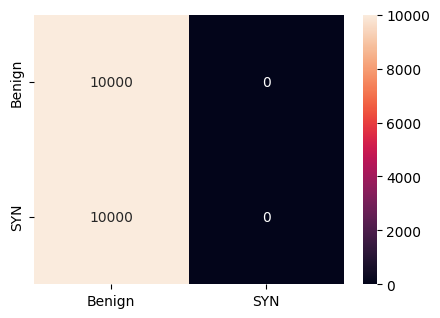





HTTP
['ts', 'TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_PSH_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   74.909    21.434
 1  HTTP          1    1     1  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   78.876    21.262
 2  HTTP          1    1     2  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   78.476    21.269
 3  HTTP          1    1     3  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   79.032    21.405
 4  HTTP          1    1     4  SVM     0.5      0.5    0.25    0.5  

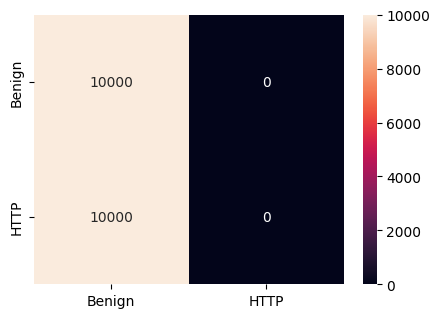





ACK
['payload_bytes_mean_WE', 'sport_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   30.5       6.789
 1  ACK           1    1     1  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   30.033     6.811
 2  ACK           1    1     2  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   30.037     6.794
 3  ACK           1    1     3  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   30.012     6.799
 4  ACK           1    1     4  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   29.976     6.791
 5  ACK           1    1     5  SVM     0.5      0.5    0.25    0.5  0.333      0    0.5   30.586     6.794
 6  ACK           1    1     6  SVM 

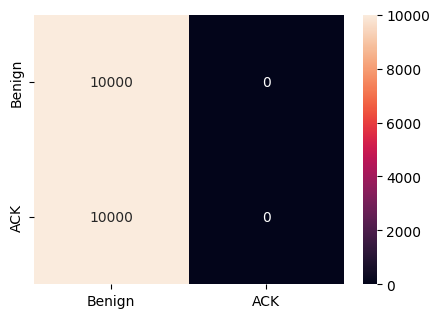





UDP
['IP_tos', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'TCP_window_sum_of_EW', 'entropy_diff', 'ts_std_2', 'TCP_window_mean_2', 'entropy_std_2', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_mean_9', 'entropy_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  SVM    0.62     0.62   0.784   0.62  0.556   0.24   0.62    0.148     0.019
 1  UDP           1    1     1  SVM    0.62     0.62   0.784   0.62  0.556   0.24   0.62    0.144     0.019
 2  UDP           1    1     2  SVM    0.62     0.62   0.784   0.62  0.556   0.24   0.62    0.145     0.019
 3  UDP           1    1     3  SVM    0.62     0.62   0.784   0.62  0.556   0.24   0

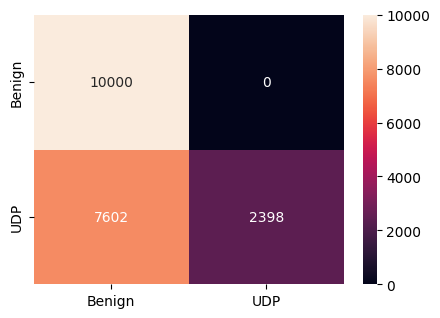





ARP
['Ether_type', 'IP_tos', 'IP_flags', 'IP_MF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_reserved', 'TCP_ACK', 'TCP_ECE', 'TCP_CWR', 'UDP_len', 'DNS_qr', 'DNS_ra', 'DNS_qdcount', 'DNS_nscount', 'DNS_arcount', 'payload_bytes', 'entropy', 'Protocol', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_mean_WE', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'entropy_mean_2', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_CWR_ratio', 'TCP_RST_SR', 'TCP_PSH_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'entropy_mean_6', 'entropy_std_6', 'pck_size_mean_9', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_std_9', 'TCP_SYN_R', 'Label']
  

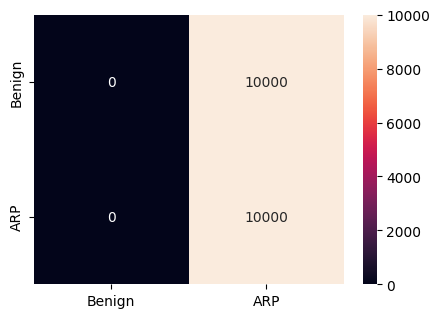





SP
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'entropy_sum_of_EW', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  SVM   0.592    0.554   0.783  0.554  0.461  0.116  0.554   13.878     4.929
 1  SP            1    1     1  SVM   0.592    0.554   0.783  0.554  0.461  0.116  0.554   13.905     4.935
 2  SP            1    1     2  SVM   0.592    0.554   0.783  0.554  0.461  0.116  0.554   13.875     4.935
 3  SP            1    1     3  SVM   0.592    0.554   0.783  0.554  0.461  0.116  0.554   13.867     4.935
 4  SP            1    1     4  SVM   0.592    0.554   0.783  0.554  0.461  0.116  0.554   13.846     4.914
 5  SP            1    1     5  SVM   0.592    0.554   0.783  0.554  0.461  0.116  0.554   13.903   

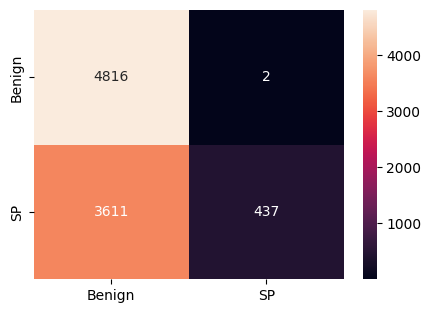





BF
['payload_bytes', 'pck_size_diff', 'TCP_window_diff', 'entropy_mean_WE', 'pck_size_mean_2', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_ratio', 'TCP_FIN_SR', 'pck_size_mean_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  SVM   0.455      0.5   0.228    0.5  0.313      0    0.5    7.045     0.195
 1  BF            1    1     1  SVM   0.455      0.5   0.228    0.5  0.313      0    0.5    7.113     0.193
 2  BF            1    1     2  SVM   0.455      0.5   0.228 

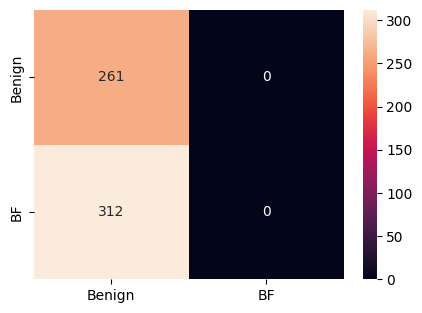





OS
['IP_ttl', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_ECE', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'dport_class', 'Protocol', 'dst_IP_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'payload_bytes_std_2', 'entropy_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_URG_ratio', 'TCP_ECE_ratio', 'TCP_CWR_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_ECE_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap   

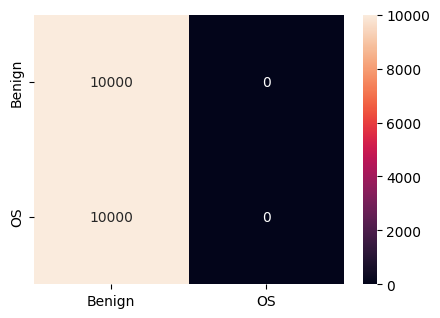





SCHD
['Ether_type', 'IP_version', 'IP_DF', 'IP_ttl', 'TCP_flags', 'TCP_options', 'dport_class', 'Protocol', 'IP_add_count', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'TCP_window_mean_WE', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'entropy_std_WE', 'pck_size_mean_2', 'ts_std_2', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  SVM   0.979      0.5    0.49    0.5  0.495      0    0.5    8.683     5.834
 1  SCHD          1    1     1  SVM   0.979      0.5    0.49    0.5  0.495      0    0.5    8.697     5.78
 2  SCHD          1    1     2  SVM   0.979     

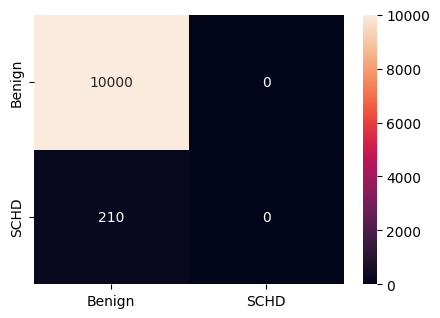





MHDis
['IP_ihl', 'IP_ttl', 'TCP_options', 'sport_class', 'Protocol', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'TCP_ACK_sum', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  SVM   0.959    0.554   0.979  0.554  0.587  0.189  0.554   14.616     5.748
 1  MHDis         1    1     1  SVM   0.959    0.554   0.979  0.554  0.587  0.189  0.554   14.694     5.727
 2  MHDis         1    1     2  SVM   0.959    0.554   0.979  0.554  0.587  0.189  0.554   14.648     5.75
 3  MHDis         1    1     3  SVM   0.959    0.554   0.979  0.554  0.587  0.189  0.554   14.608     5.738
 4  MHDis         1    1     4  SVM   0.959    0.55

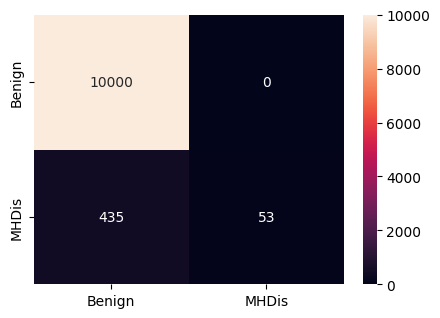

In [21]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  


In [22]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]


    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

100%|██████████████████████████████████████████| 80/80 [00:00<00:00, 297.52it/s]

    Attack    ML         Acc     b_Acc      Prec       Rec        F1           kap       ROC         tra-T         test-T
--  --------  ----  --------  --------  --------  --------  --------  ------------  --------  ------------  -------------
 0  UDP       LR    0.25457   0.620131  0.512321  0.620131  0.217768   0.0117714    0.620131    0.420081      0.177332
 1  BF        MLP   0.536475  0.570914  0.667022  0.570914  0.470993   0.132625     0.570914  117.832         0.0140799
 2  OS        LR    0.8533    0.8533    0.881374  0.8533    0.85034    0.7066       0.8533      0.0431882     0.00160675
 3  ACK       NB    0.612672  0.735124  0.704861  0.735124  0.610482   0.323091     0.735124    0.00262361    0.0138357
 4  HTTP      XGB   1         1         1         1         1          1            1           2.09835       0.0148726
 5  MHDis     LR    0.999619  0.9998    0.995935  0.9998    0.997859   0.995718     0.9998      0.22569       0
 6  ACK       SVM   0.5       0.5       0.25

In [23]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)

UDP
BF
OS
ACK
HTTP
MHDis
SCHD
SYN
ARP
SP
